In [1]:
import os

os.environ[
    "OMP_NUM_THREADS"
] = "64"  # for jupyter.nersc.gov otherwise the notebook only uses 2 cores

In [2]:
from pathlib import Path
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

# import pymaster as nmt
from astropy.io import fits

%matplotlib inline

In [3]:
plt.style.use("seaborn-talk")

In [4]:
import pysm3 as pysm
import pysm3.units as u

In [5]:
nside = 512
lmax = 3 * nside - 1

In [6]:
comp = "IQU"

In [7]:
components = list(enumerate(comp))
components

[(0, 'I'), (1, 'Q'), (2, 'U')]

In [8]:
spectra_components = ["TT", "EE", "BB"]

change this to True   if you want to  run namaster on notebook 


In [9]:
!rm -f data/synch_*_spectra.npz

In [10]:
namaster_on_nb = True

In [11]:
datadir = Path("data")

In [12]:
output_dir = Path("production-data/synch")

In [13]:
imapfile = datadir / "haslam408_dsds_Remazeilles2014.fits"
qumapfile = datadir / "wmap_band_iqumap_r9_9yr_K_v5.fits"

In [14]:
if not imapfile.exists():
    !wget -O $imapfile   https://lambda.gsfc.nasa.gov/data/foregrounds/haslam_2014/haslam408_dsds_Remazeilles2014.fits

In [15]:
if not qumapfile.exists():
    !wget -O $qumapfile   https://lambda.gsfc.nasa.gov/data/map/dr5/skymaps/9yr/raw/wmap_band_iqumap_r9_9yr_K_v5.fits

In [16]:
imap = hp.read_map(imapfile)
qumap = hp.read_map(qumapfile, field=[1, 2])


# Setting the inputs 
## Synchrotron   maps 
- We use the Haslam map at 408MHz for the intensity template 
- for Q and U we adopt maps from the K-band of WMAP .  


- rescaling Haslam map to 23 GHz **assuming a constant spectral index =-3.1**   and from K to uK 
- converting Wmap maps to from mK to uK  
- we reduce noise by smoothing to 2 deg 



In [17]:
rescaling_factor = (23.0 / 0.408) ** -3.1

imap *= rescaling_factor
imap <<= u.K_RJ
imap = imap.to(u.uK_RJ)
qumap <<= u.mK_RJ
qumap = qumap.to("uK_RJ")

In [18]:
IQU = np.array([imap, qumap[0], qumap[1]])

In [19]:
FWHM_SMOOTHING = 2  # deg
IQU = hp.smoothing(IQU, fwhm=np.radians(FWHM_SMOOTHING))
IQU <<= u.uK_RJ

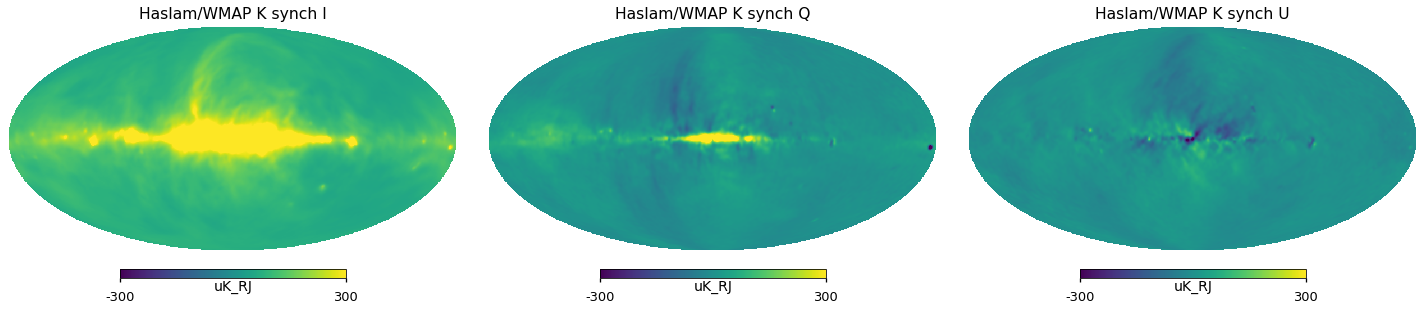

In [20]:
plt.figure(figsize=(20, 5))
for i_pol, pol in components:
    hp.mollview(
        IQU[i_pol],
        title="Haslam/WMAP K synch " + pol,
        sub=131 + i_pol,
        unit=IQU.unit,
        min=-300,
        max=300,
    )

In [21]:
from pysm3.utils import map_to_log_pol_tens, log_pol_tens_to_map, sigmoid

In [22]:
iqu = map_to_log_pol_tens(IQU.value)

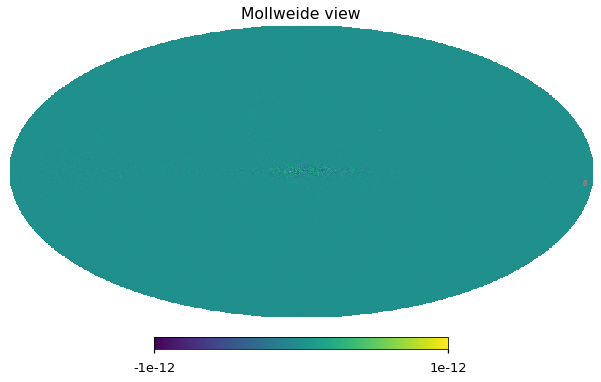

In [23]:
m_back = log_pol_tens_to_map(iqu)
hp.mollview((IQU.value - m_back)[1], min=-1e-12, max=1e-12)
del m_back

In [24]:
print(
    f"{np.isnan(iqu[0]).sum()  } pixels out of { iqu[0].size} are NaNs in Log Pol Tens maps "
)
for i in range(3):
    iqu[i, np.isnan(iqu[i])] = np.nanmedian(iqu[i])
assert np.isnan(iqu).sum() == 0
print(
    f"{np.isnan(iqu[0]).sum()  } pixels out of { iqu[0].size} are NaNs in Log Pol Tens maps "
)

527 pixels out of 3145728 are NaNs in Log Pol Tens maps 
0 pixels out of 3145728 are NaNs in Log Pol Tens maps 


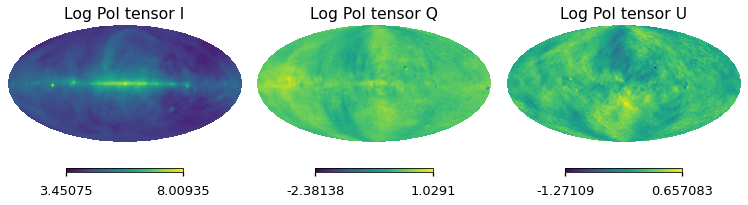

In [25]:
for i_pol, pol in components:
    hp.mollview(iqu[i_pol], title="Log Pol tensor " + pol, sub=131 + i_pol)

In [26]:
from scipy.optimize import curve_fit

In [27]:
def model(ell, A, gamma):
    out = A * ell ** gamma
    out[:2] = 0
    return out

In [28]:
def run_anafast(m, lmax):
    clanaf = hp.anafast(m, lmax=lmax)
    cl = {}
    cl["TT"] = clanaf[0]
    cl["EE"] = clanaf[1]
    cl["BB"] = clanaf[2]
    ell = np.arange(lmax + 1)

    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl


def run_namaster(m, mask, lmax):
    """Compute C_ell with NaMaster
    Parameters
    ----------
    m : numpy array
        T only or TQU HEALPix map
    mask : numpy array
        mask, 1D, 0 for masked pixels,
        needs to have same Nside of the input map
    lmax : int
        maximum ell of the spherical harmonics transform
    Returns
    -------
    ell : numpy array
        array of ell from 0 to lmax (length lmax+1)
    cl_norm : numpy array
        ell (ell+1)/2pi factor to turn C_ell into D_ell
        first element is set to 1
    cl : dict of numpy arrays
        dictionary of numpy arrays with all components
        of the spectra, for now only II, EE, BB, no
        cross-spectra
    """
    nside = hp.npix2nside(len(mask))

    binning = nmt.NmtBin(nside=nside, nlb=1, lmax=lmax, is_Dell=False)

    cl = {}

    f_0 = nmt.NmtField(mask, [m[0]])

    if len(m) == 3:
        f_2 = nmt.NmtField(mask, m[1:].copy())  # NaMaster masks the map in-place
        cl_namaster = nmt.compute_full_master(f_2, f_2, binning)
        cl["EE"] = np.concatenate([[0, 0], cl_namaster[0]])
        cl["BB"] = np.concatenate([[0, 0], cl_namaster[3]])
        cl_namaster = nmt.compute_full_master(f_0, f_2, binning)
        cl["TE"] = np.concatenate([[0, 0], cl_namaster[0]])
    elif m.ndim == 1:
        m = m.reshape((1, -1))

    cl_namaster_I = nmt.compute_full_master(f_0, f_0, binning)

    cl["TT"] = np.concatenate([[0, 0], cl_namaster_I[0]])
    ell = np.concatenate([[0, 1], binning.get_effective_ells()])
    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl

In [29]:
print("run anafast on masked sky  ")
ell, cl_norm, cl = run_anafast(iqu, lmax)

run anafast on masked sky  


## Power law fit 

- We fit in$\ell \in[1-,36]$ a power law for TT spectrum of the logpol tens i map
- we use the spectral index power law also for EE and BB power spectra to avoid unphysical crossings of EE over TT and BB over TT at higher multipoles


B-to-E ratio at l= 36 , 0.5411971105467793
B-to-E ratio at l= 36 , 0.4224582013879322


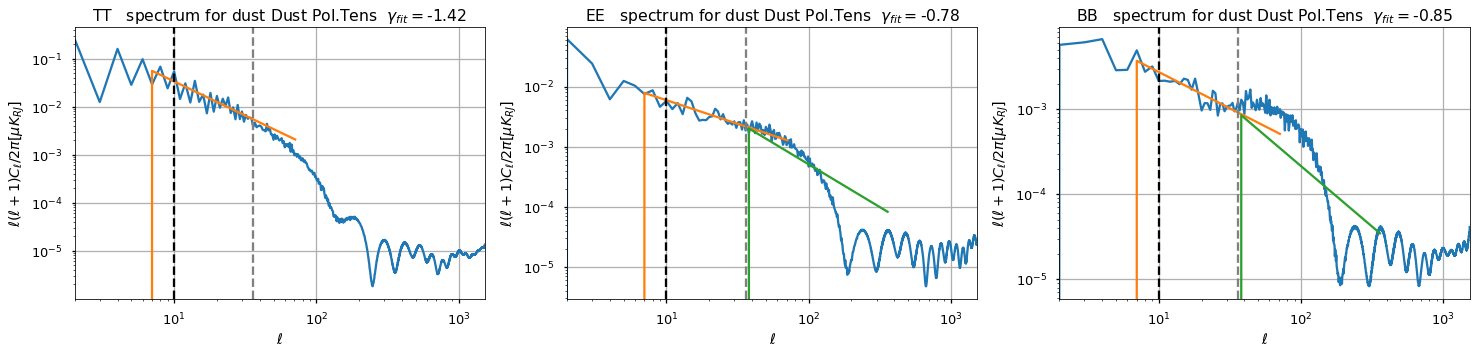

In [30]:
ell_fit_low = {"TT": 10, "EE": 10, "BB": 10}
ell_fit_high = {"TT": 36, "EE": 36, "BB": 36}
A_fit, gamma_fit, A_fit_std, gamma_fit_std = {}, {}, {}, {}
plt.figure(figsize=(25, 5))

for ii, pol in enumerate(spectra_components):
    plt.subplot(131 + ii)
    xdata = np.arange(ell_fit_low[pol], ell_fit_high[pol])
    ydata = xdata * (xdata + 1) / np.pi / 2 * cl[pol][xdata]
    (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)
    A_fit_std[pol], gamma_fit_std[pol] = np.sqrt(np.diag(cov))

    plt.loglog(ell, ell * (ell + 1) / np.pi / 2 * cl[pol], label="Anafast $C_\ell$")

    plt.plot(
        ell[ell_fit_low[pol] // 2 : ell_fit_high[pol] * 2],
        model(
            ell[ell_fit_low[pol] // 2 : ell_fit_high[pol] * 2],
            A_fit[pol],
            gamma_fit[pol],
        ),
        label="old model fit",
    )

    plt.axvline(
        ell_fit_low[pol],
        linestyle="--",
        color="black",
        label="$ \ell={} $".format(ell_fit_low[pol]),
    )
    plt.axvline(
        ell_fit_high[pol],
        linestyle="--",
        color="gray",
        label="$ \ell={} $".format(ell_fit_high[pol]),
    )
    plt.grid()
    plt.title(
        f"{pol}   spectrum for dust Dust Pol.Tens  "
        + r"$\gamma_{fit}=$"
        + f"{gamma_fit[pol]:.2f}"
    )

    plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
    plt.xlabel(("$\ell$"))
    plt.xlim(2, lmax)

print(f"B-to-E ratio at l= {ell_fit_high['BB']} , { A_fit['BB']/A_fit['EE' ]}")

for ii, pol in enumerate(spectra_components[1:]):
    # we change the EE and BB power laws
    A_fit[pol] = A_fit[pol] * ell_fit_high[pol] ** (gamma_fit[pol] - gamma_fit["TT"])
    gamma_fit[pol] = gamma_fit["TT"]
    plt.subplot(132 + ii)
    plt.plot(
        ell[ell_fit_high[pol] : ell_fit_high[pol] * 10],
        model(
            ell[ell_fit_high[pol] : ell_fit_high[pol] * 10], A_fit[pol], gamma_fit[pol]
        ),
        label="new power law",
    )

print(f"B-to-E ratio at l= {ell_fit_high['BB']} , { A_fit['BB']/A_fit['EE' ]}")

### Define Modulation maps 
as suggested by Ben Thorne , 
the injected small scales are at different multipoles for intensity and polarization, we consider 2 different modulation maps  

#### Modulation for  polarization : 
- smooth `i` map to 5 deg 
- we saturate all the pixels >5.5 to 1.5 
- reduce the dynamic range to range from .5 to 1.5 with MinMax rescaling  

#### Modulation for  intensity : 
- smooth `i` map to 5 deg 
- for  the pixels >5  MinMax rescaling from 1.1 to 2 
- elsewhere MinMax rescaling  from  .1 to 1.1   

In [31]:
ismooth = hp.smoothing(iqu[0], fwhm=np.radians(5))

In [32]:
minmax = lambda m, a, b: a + (b - a) * (m - m.min()) / (m.max() - m.min())

modulate_amp_pol = (ismooth) * 1.0
modulate_amp = (ismooth) * 1.0

mskmd = ismooth > 5.5
b1 = 1.5
a = 0.5

modulate_amp_pol[mskmd] = 1.5
modulate_amp_pol[~mskmd] = minmax(ismooth[~mskmd], 0.5, 1.5)
mskmd = ismooth > 5

modulate_amp[mskmd] = minmax(ismooth[mskmd], 1.1, 2)
modulate_amp[~mskmd] = minmax(ismooth[~mskmd], 0.1, 1.1)

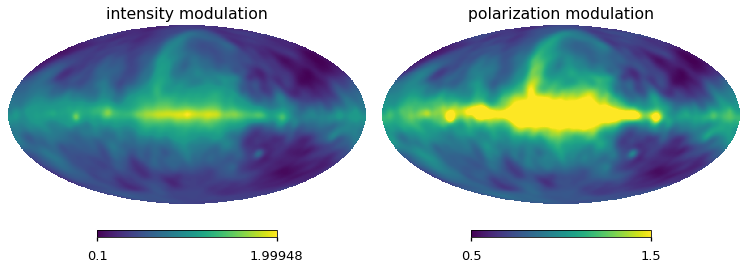

In [33]:
hp.mollview(modulate_amp, title="intensity modulation", sub=121)
hp.mollview(modulate_amp_pol, title="polarization modulation", sub=122)

In [34]:
output_nside = 2048
output_lmax = 2 * output_nside
output_ell = np.arange(output_lmax + 1)
output_cl_norm = output_ell * (output_ell + 1) / np.pi / 2
output_cl_norm[0] = 1

In [35]:
modulate_alm = {}
for name, each_modulate in [("temperature", modulate_amp), ("polarization", modulate_amp_pol)]:
    modulate_alm[name] = hp.map2alm(each_modulate, lmax=lmax, use_pixel_weights=True)
    if output_nside > 4096:

        hp.write_alm(output_dir / "raw" / f"synch_{name}_modulation_alms_lmax{int(lmax):d}.fits",
             modulate_alm[name], overwrite=True, out_dtype=np.float32)
del modulate_amp, modulate_amp_pol, each_modulate

In [36]:
np.random.seed(555)
# filter small scales
small_scales_input_cl = [
    1
    * model(output_ell, A_fit[pol], gamma_fit[pol])
    * sigmoid(output_ell, ell_fit_high[pol], ell_fit_high[pol] / 10)
    / output_cl_norm
    for pol in spectra_components
]

if output_nside > 4096:

    hp.write_cl(
        output_dir / "raw" / f"synch_small_scales_logpoltens_cl_lmax{output_lmax}.fits",
        small_scales_input_cl,
        dtype=np.complex128,
        overwrite=True,
    )

ii_SS_alm = hp.synalm(
    small_scales_input_cl + [np.zeros_like(small_scales_input_cl[0])] * 3,
    lmax=lmax,
    new=True,
)


# filter large scales
alm_log_pol_tens_fullsky = hp.map2alm(iqu, lmax=lmax, use_pixel_weights=True)
ii_LS_alm = np.empty_like(alm_log_pol_tens_fullsky)

for ii, pol in enumerate(spectra_components):

    sig_func = sigmoid(ell, x0=ell_fit_high[pol], width=ell_fit_high[pol] / 10)
    ii_LS_alm[ii] = hp.almxfl(alm_log_pol_tens_fullsky[ii], (1.0 - sig_func) ** 0.2)

log_ss = hp.alm2map(ii_SS_alm, nside=output_nside)
modulate_amp = hp.alm2map(modulate_alm["temperature"], output_nside)

log_ss[0] *= modulate_amp
modulate_amp_pol = hp.alm2map(modulate_alm["polarization"], output_nside)
log_ss[1:] *= modulate_amp_pol

if output_nside > 4096:

    hp.write_alm(
        output_dir / "raw" / f"synch_largescale_template_logpoltens_alm_nside{nside}_lmax{lmax:d}_complex64.fits",
        ii_LS_alm,
        lmax=lmax,
        out_dtype=np.complex64,
        overwrite=True,
    )

log_ls = hp.alm2map(ii_LS_alm, nside=output_nside)
ii_map_out = log_ss + log_ls

/tmp/ipykernel_48350/3589521984.py:2: RuntimeWarning: divide by zero encountered in power
  out = A * ell ** gamma


In [37]:
output_map_alm = hp.map2alm(ii_map_out, lmax=output_lmax)

In [38]:
if output_nside > 4096:

    hp.write_alm(
        output_dir / "raw" / f"dust_gnilc_template_alm_nside{output_nside}_lmax{output_lmax}_complex64.fits",
        output_map_alm,
        out_dtype = np.complex64,
        overwrite=True,
    )

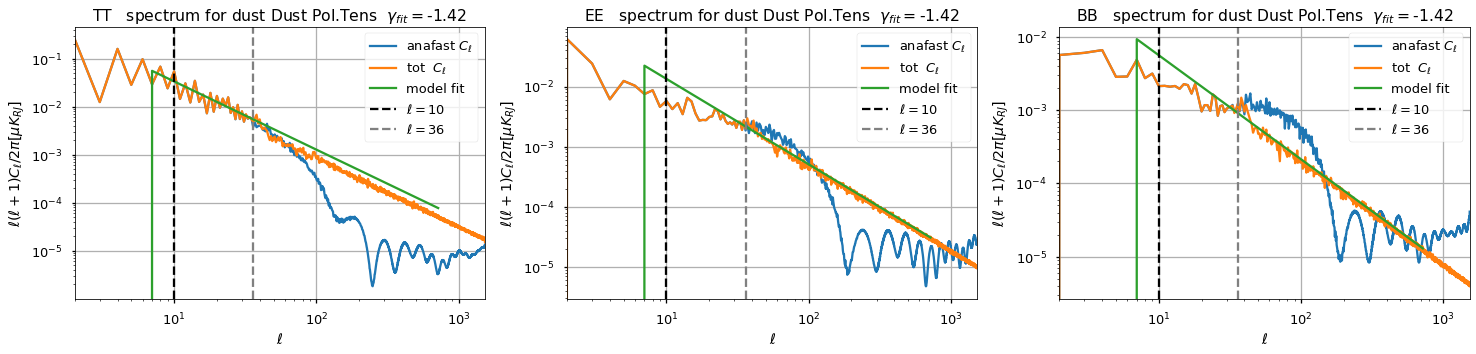

In [39]:

if output_nside < 4096:
    ell, cl_norm, cltot = run_anafast(ii_map_out, lmax)
    plt.figure(figsize=(25, 5))

    for ii, pol in enumerate(spectra_components):
        plt.subplot(131 + ii)
        plt.loglog(ell, ell * (ell + 1) / np.pi / 2 * cl[pol], label="anafast $C_\ell$")
        plt.loglog(ell, ell * (ell + 1) / np.pi / 2 * cltot[pol], label="tot  $C_\ell$")

        plt.plot(
            ell[ell_fit_low[pol] // 2 : ell_fit_high[pol] * 20],
            model(
                ell[ell_fit_low[pol] // 2 : ell_fit_high[pol] * 20],
                A_fit[pol],
                gamma_fit[pol],
            ),
            label="model fit",
        )

        plt.axvline(
            ell_fit_low[pol],
            linestyle="--",
            color="black",
            label="$ \ell={} $".format(ell_fit_low[pol]),
        )
        plt.axvline(
            ell_fit_high[pol],
            linestyle="--",
            color="gray",
            label="$ \ell={} $".format(ell_fit_high[pol]),
        )
        plt.legend()
        plt.grid()
        plt.title(
            f"{pol}   spectrum for dust Dust Pol.Tens  "
            + r"$\gamma_{fit}=$"
            + f"{gamma_fit[pol]:.2f}"
        )

        plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
        plt.xlabel(("$\ell$"))
        plt.xlim(2, lmax)

In [40]:
output_map = log_pol_tens_to_map(ii_map_out)

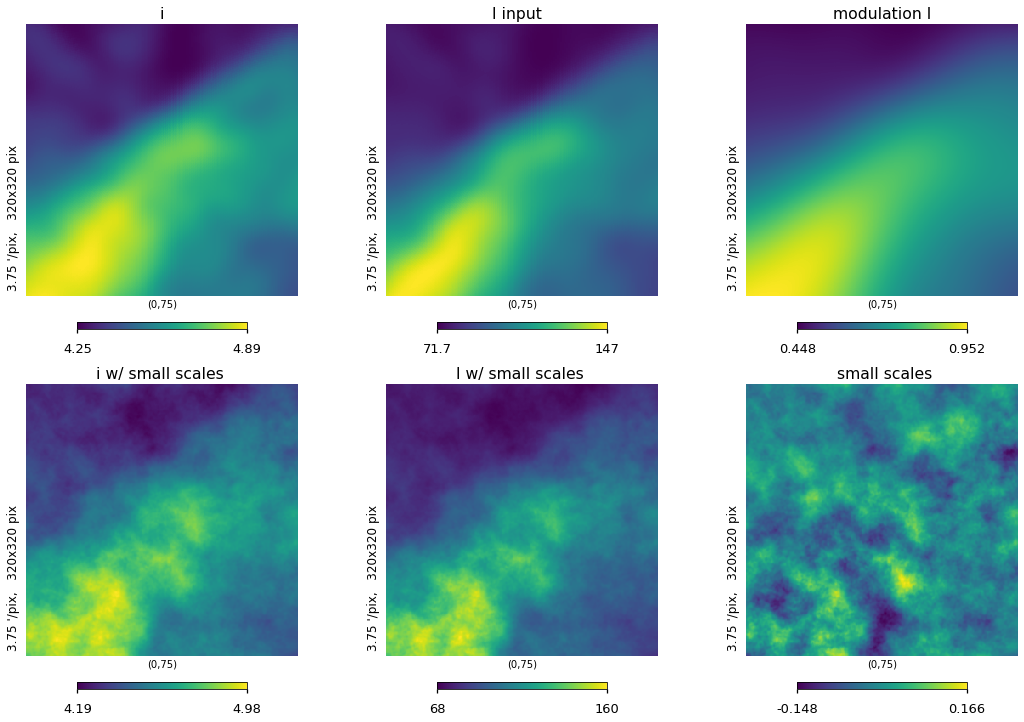

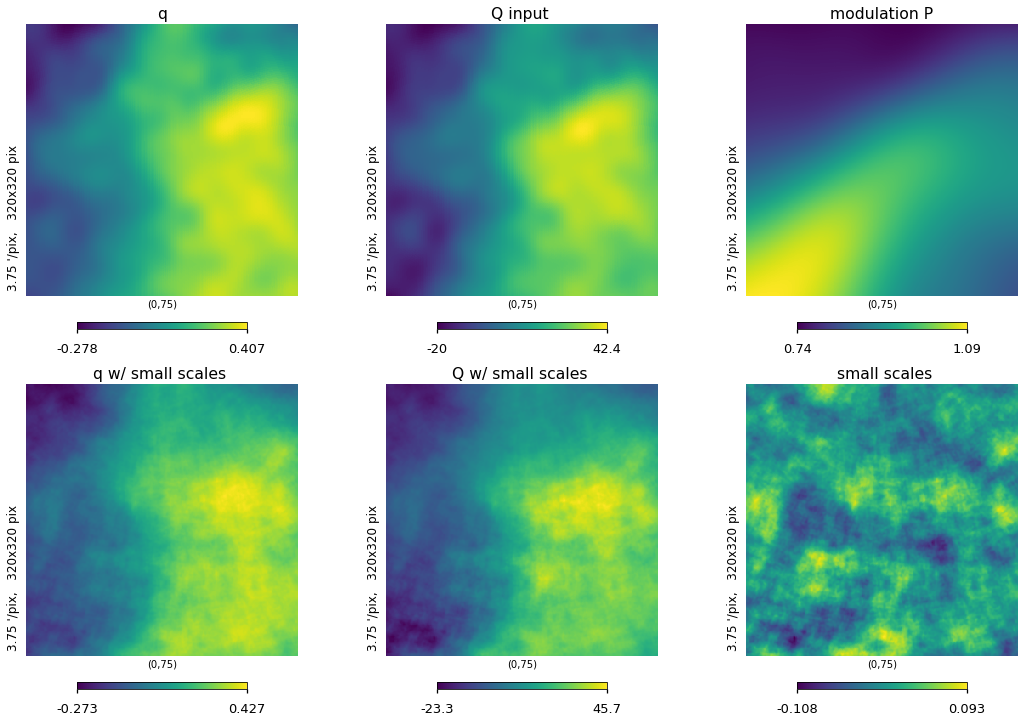

In [41]:
if output_nside < 4096:
    lat = 75
    plt.figure(figsize=(15, 10))
    hp.gnomview(
        ii_map_out[0],
        title="i w/ small scales ",
        rot=[0, lat],
        reso=3.75,
        xsize=320,
        sub=234,
    )
    hp.gnomview(iqu[0], title="i", rot=[0, lat], reso=3.75, xsize=320, sub=231)
    hp.gnomview(
        modulate_amp,
        title=" modulation I ",
        rot=[0, lat],
        reso=3.75,
        xsize=320,
        sub=233,
    )

    hp.gnomview(
        (IQU[0]),
        title=" I input   ",
        rot=[0, lat],
        reso=3.75,
        xsize=320,
        sub=232,
    )
    hp.gnomview(
        (log_ss)[0],
        title="  small scales ",
        rot=[0, lat],
        reso=3.75,
        xsize=320,
        sub=236,
    )
    hp.gnomview(
        output_map[0],
        title="I w/ small scales ",
        rot=[0, lat],
        reso=3.75,
        xsize=320,
        sub=235,
    )
    lat = 75
    plt.figure(figsize=(15, 10))
    hp.gnomview(
        ii_map_out[1],
        title="q w/ small scales ",
        rot=[0, lat],
        reso=3.75,
        xsize=320,
        sub=234,
    )
    hp.gnomview(iqu[1], title="q", rot=[0, lat], reso=3.75, xsize=320, sub=231)
    hp.gnomview(
        (modulate_amp_pol),
        title=" modulation P ",
        rot=[0, lat],
        reso=3.75,
        xsize=320,
        sub=233,
    )

    hp.gnomview(
        (IQU[1]),
        title=" Q input  ",
        rot=[0, lat],
        reso=3.75,
        xsize=320,
        sub=232,
    )
    hp.gnomview(
        (log_ss)[1],
        title="  small scales ",
        rot=[0, lat],
        reso=3.75,
        xsize=320,
        sub=236,
    )
    hp.gnomview(
        output_map[1],
        title="Q w/ small scales ",
        rot=[0, lat],
        reso=3.75,
        xsize=320,
        sub=235,
    )

### Validation 


In [42]:
bk15_mask_filename = datadir / "BK15_region_Gal_apo.fits"
if not bk15_mask_filename.exists():
    !wget -O $bk15_mask_filename https://portal.nersc.gov/project/cmb/pysm-data/gnilc/inputs/BK15_region_Gal_apo.fits

In [43]:
if output_nside < 4096:
    planck_masks = {
        k.lower(): hp.read_map(datadir / "HFI_Mask_GalPlane-apo2_2048_R2.00.fits", [k])
        for k in ["GAL{:03d}".format(frac) for frac in [20, 40, 80]]
    }

    planck_masks["BK"] = hp.read_map(bk15_mask_filename)

In [44]:
if output_nside < 4096:


    planck_masks_512 = {k:hp.ud_grade(v, 512) for k,v in planck_masks.items()}


In [45]:
if output_nside < 4096:

    for k, v in planck_masks.items():
        planck_masks[k] = hp.ud_grade(v, output_nside)

In [46]:
nlb = {"BK": 35, "gal020": 25, "gal040": 15, "gal080": 4}

In [47]:
import pymaster as nmt

In [48]:
def run_namaster(m, mask, lmax, nlbins=1):
    """Compute C_ell with NaMaster
    Parameters
    ----------
    m : numpy array
        T only or TQU HEALPix map
    mask : numpy array
        mask, 1D, 0 for masked pixels,
        needs to have same Nside of the input map
    lmax : int
        maximum ell of the spherical harmonics transform
    Returns
    -------
    ell : numpy array
        array of ell from 0 to lmax (length lmax+1)
    cl_norm : numpy array
        ell (ell+1)/2pi factor to turn C_ell into D_ell
        first element is set to 1
    cl : dict of numpy arrays
        dictionary of numpy arrays with all components
        of the spectra, for now only II, EE, BB, no
        cross-spectra
    """
    nside = hp.npix2nside(len(mask))

    binning = nmt.NmtBin(nside=nside, nlb=nlbins, lmax=lmax, is_Dell=False)

    cl = {}

    f_0 = nmt.NmtField(mask, [m[0].copy()])

    if len(m) == 3:
        f_2 = nmt.NmtField(mask, m[1:].copy())  # NaMaster masks the map in-place
        cl_namaster = nmt.compute_full_master(f_2, f_2, binning)
        cl["EE"] = np.concatenate([[0, 0], cl_namaster[0]])
        cl["BB"] = np.concatenate([[0, 0], cl_namaster[3]])
        cl_namaster = nmt.compute_full_master(f_0, f_2, binning)
        cl["TE"] = np.concatenate([[0, 0], cl_namaster[0]])
    elif m.ndim == 1:
        m = m.reshape((1, -1))

    cl_namaster_I = nmt.compute_full_master(f_0, f_0, binning)

    cl["TT"] = np.concatenate([[0, 0], cl_namaster_I[0]])
    ell = np.concatenate([[0, 1], binning.get_effective_ells()])
    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl

read Namaster spectra  
run Namaster  


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


read Namaster spectra  
run Namaster  


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


read Namaster spectra  
run Namaster  


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


read Namaster spectra  
run Namaster  


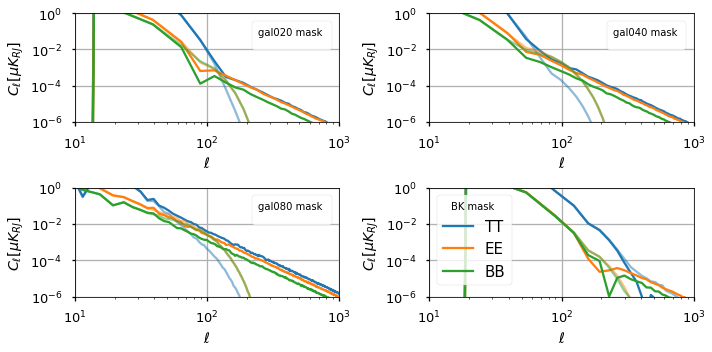

In [49]:
if output_nside < 4096:

    plt.figure(figsize=(10, 5))

    for jj, k in enumerate(planck_masks.keys()):
        fspectra = datadir / f"sync_hybrid_out_{k}_spectra.npz"
        if os.path.exists(fspectra):
            print("read Namaster spectra  ")
            output_ell = np.load(fspectra)["ell"]
            cl_out = {kk: np.load(fspectra)[kk] for kk in spectra_components}
        elif namaster_on_nb:
            print("run Namaster  ")
            output_ell, output_cl_norm, cl_out = run_namaster(
                output_map, mask=planck_masks[k], lmax=output_lmax, nlbins=nlb[k]
            )
            np.savez(fspectra, ell=output_ell, cl_norm=output_cl_norm, **cl_out)

        fspectra = datadir / f"synch_hybrid_{k}_spectra.npz"
        if os.path.exists(fspectra):
            print("read Namaster spectra  ")
            input_ell = np.load(fspectra)["ell"]
            cl_in = {kk: np.load(fspectra)[kk] for kk in spectra_components}
        elif namaster_on_nb:
            print("run Namaster  ")
            input_ell, input_cl_norm, cl_in = run_namaster(
                IQU, mask=planck_masks_512[k], lmax=lmax, nlbins=nlb[k]
            )
            np.savez(fspectra, ell=input_ell, cl_norm=input_cl_norm, **cl_in)
        plt.subplot(2, 2, jj + 1)
        for ii, pol in enumerate(["TT", "EE", "BB"]):
            if jj == 3:

                plt.loglog(output_ell, abs(cl_out[pol]), color="C%d" % ii, label=pol)
            else:
                plt.loglog(
                    output_ell,
                    abs(cl_out[pol]),
                    color="C%d" % ii,
                )
            plt.loglog(
                input_ell,
                abs(cl_in[pol]),
                color="C%d" % ii,
                alpha=0.5,
            )

            plt.grid()
            plt.legend(title=(k + " mask "), fontsize=15)
            plt.ylabel("$ C_\ell  [\mu K_{RJ}]$")
            plt.xlabel(("$\ell$"))
            plt.xlim(10, 1e3)
            plt.ylim(1e-6, 1e0)
    plt.tight_layout()

/tmp/ipykernel_48350/3690582689.py:39: RuntimeWarning: invalid value encountered in true_divide
  cl_out["BB"] / cl_out["EE"],
/tmp/ipykernel_48350/3690582689.py:44: RuntimeWarning: invalid value encountered in true_divide
  cl_in["BB"] / cl_in["EE"],
No handles with labels found to put in legend.
/tmp/ipykernel_48350/3690582689.py:39: RuntimeWarning: invalid value encountered in true_divide
  cl_out["BB"] / cl_out["EE"],
/tmp/ipykernel_48350/3690582689.py:44: RuntimeWarning: invalid value encountered in true_divide
  cl_in["BB"] / cl_in["EE"],
No handles with labels found to put in legend.
/tmp/ipykernel_48350/3690582689.py:39: RuntimeWarning: invalid value encountered in true_divide
  cl_out["BB"] / cl_out["EE"],
/tmp/ipykernel_48350/3690582689.py:44: RuntimeWarning: invalid value encountered in true_divide
  cl_in["BB"] / cl_in["EE"],
No handles with labels found to put in legend.
/tmp/ipykernel_48350/3690582689.py:39: RuntimeWarning: invalid value encountered in true_divide
  cl_ou

read Namaster spectra  
read Namaster spectra  
read Namaster spectra  
read Namaster spectra  
read Namaster spectra  
read Namaster spectra  
read Namaster spectra  
read Namaster spectra  


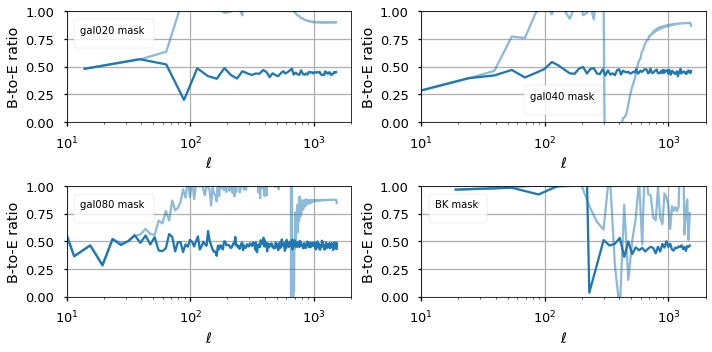

In [50]:
if output_nside < 4096:

    plt.figure(figsize=(10, 5))

    for jj, k in enumerate(planck_masks.keys()):
        fspectra = datadir / f"sync_hybrid_out_{k}_spectra.npz"
        if os.path.exists(fspectra):
            print("read Namaster spectra  ")
            output_ell = np.load(fspectra)["ell"]
            cl_out = {kk: np.load(fspectra)[kk] for kk in spectra_components}
        elif namaster_on_nb:
            print("run Namaster  ")
            output_ell, output_cl_norm, cl_out = run_namaster(
                output_map, mask=planck_masks[k], lmax=output_lmax, nlbins=nlb[k]
            )
            np.savez(fspectra, ell=output_ell, cl_norm=output_cl_norm, **cl_out)

        # else:
        #    print("run anafast on masked sky  ")
        #    output_ell, cl_norm, cl_out = run_anafast(output_map * planck_mask, lmax)

        fspectra = datadir / f"synch_hybrid_{k}_spectra.npz"
        if os.path.exists(fspectra):
            print("read Namaster spectra  ")
            input_ell = np.load(fspectra)["ell"]
            cl_in = {kk: np.load(fspectra)[kk] for kk in spectra_components}
        elif namaster_on_nb:
            print("run Namaster  ")
            input_ell, input_cl_norm, cl_in = run_namaster(
                m_planck_varres, mask=planck_masks[k], lmax=output_lmax, nlbins=nlb[k]
            )
            np.savez(fspectra, ell=input_ell, cl_norm=input_cl_norm, **cl_in)
        # else:
        #    print("run anafast on masked sky  ")
        #    ell, cl_norm, cl_out = run_anafast(output_map * planck_mask, lmax)
        plt.subplot(2, 2, jj + 1)
        plt.semilogx(
            output_ell,
            cl_out["BB"] / cl_out["EE"],
            color="C%d" % 0,
        )
        plt.semilogx(
            input_ell,
            cl_in["BB"] / cl_in["EE"],
            color="C%d" % 0,
            alpha=0.5,
        )
        plt.grid()
        plt.legend(title=(k + " mask "), fontsize=15)
        plt.ylabel(("B-to-E ratio"))
        plt.xlabel(("$\ell$"))
        plt.ylim(0, 1)
        plt.xlim(10, 2e3)

    plt.tight_layout()

In [51]:
get_polfrac = lambda m: np.sqrt(m[1] ** 2 + m[2] ** 2) / m[0]

In [52]:
if output_nside < 4096:

    Pout = get_polfrac(output_map)
    Pin = get_polfrac(IQU.value)

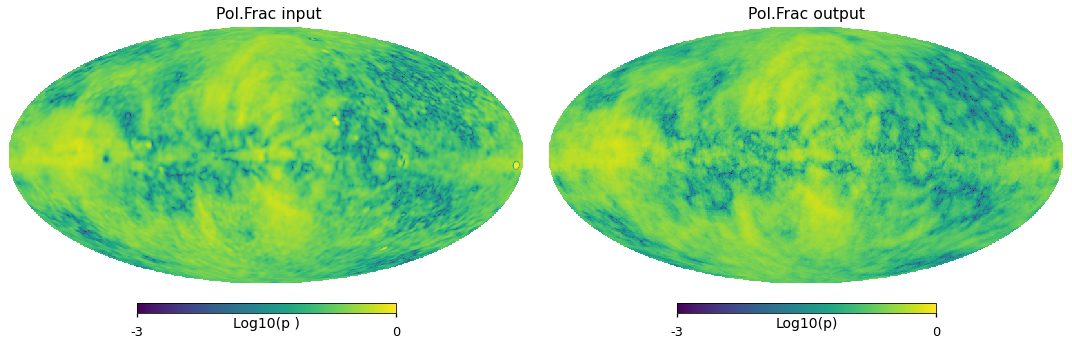

In [53]:
if output_nside < 4096:

    plt.figure(figsize=(15, 5))
    hp.mollview(
        np.log10(Pin), title=" Pol.Frac input", sub=121, min=-3, max=0, unit="Log10(p )"
    )
    hp.mollview(
        np.log10(Pout), title="Pol.Frac output", sub=122, min=-3, max=0, unit="Log10(p)"
    )

In [54]:
if output_nside < 4096:

    logpin = np.log10(Pin)
    logpout = np.log10(Pout)

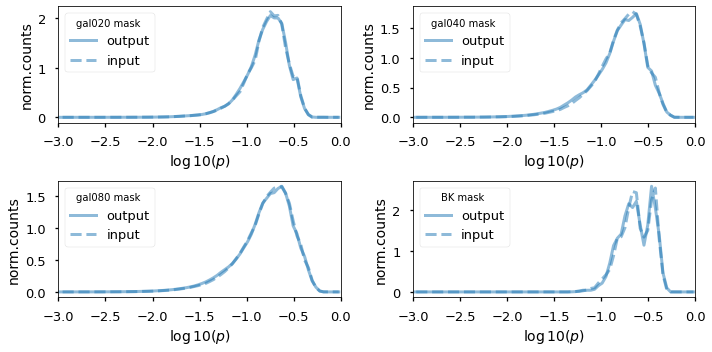

In [55]:
if output_nside < 4096:

    plt.figure(figsize=(10, 5))

    for jj, pm in enumerate(planck_masks.items()):
        k = pm[0]
        msk = np.round(pm[1]).astype(bool)
        msk_512 = np.round(planck_masks_512[k]).astype(bool)

        plt.subplot(2, 2, jj + 1)

        h, edg = np.histogram(logpout[msk], bins=np.linspace(-4, 0, 100), density=True)
        xb = np.array([(edg[i] + edg[i + 1]) / 2 for i in range(edg.size - 1)])

        plt.plot(xb, h, lw=3, color="C0", alpha=0.5, label="output")
        h, edg = np.histogram(logpin[msk_512], density=True, bins=np.linspace(-4, 0, 100))
        xb = np.array([(edg[i] + edg[i + 1]) / 2 for i in range(edg.size - 1)])

        plt.plot(xb, h, lw=3, alpha=0.5, color="C0", linestyle="--", label="input")
        plt.ylabel("norm.counts", fontsize=14)
        plt.xlabel(r"$\log10( p )$", fontsize=14)
        plt.legend(title=(k + " mask "), fontsize=13, loc="best")
        plt.xlim(-3, -0.0)
    plt.tight_layout()